<a href="https://colab.research.google.com/github/chihina/pytorch-tutorial/blob/master/3_1_audio_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Tutorial 3-1: Audio I/O and Pre-Processing with torchaudio**  
https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html

# Overview

In this tutorial, we will see how to load and preprocess audio data from a simple dataset.

In [1]:
!pip install torchaudio
import torch
import torchaudio
import requests
import matplotlib.pyplot as plt

     |████████████████████████████████| 7.6MB 9.6MB/s 
     |████████████████████████████████| 776.8MB 22kB/s 
ERROR: torchvision 0.8.1+cu101 has requirement torch==1.7.0, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101


/usr/local/lib/python3.6/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


# Opening a file

Shape of waveform: torch.Size([2, 276858])
Sample rate of waveform: 44100


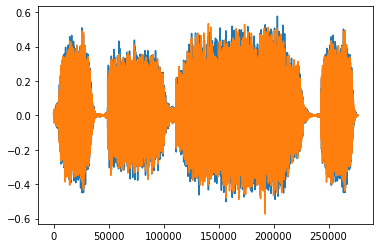

In [2]:
url = "https://pytorch.org/tutorials/_static/img/steam-train-whistle-daniel_simon-converted-from-mp3.wav"
r = requests.get(url)

with open('steam-train-whistle-daniel_simon-converted-from-mp3.wav', 'wb') as f:
    f.write(r.content)

filename = "steam-train-whistle-daniel_simon-converted-from-mp3.wav"
waveform, sample_rate = torchaudio.load(filename)

print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.figure()
plt.plot(waveform.t().numpy())

# Transformations

torchaudio supports many transformation methods about audio

## Spectrogram


Shape of spectrogram: torch.Size([2, 201, 1385])


/usr/local/lib/python3.6/dist-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/usr/local/lib/python3.6/dist-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


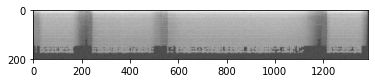

In [3]:
specgram = torchaudio.transforms.Spectrogram()(waveform)

print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure()
plt.imshow(specgram.log2()[0,:,:].numpy(), cmap='gray')

## Mel Spectrogram

/usr/local/lib/python3.6/dist-packages/torchaudio/functional.py:318: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


Shape of spectrogram: torch.Size([2, 128, 1385])


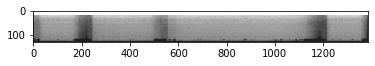

In [5]:
specgram = torchaudio.transforms.MelSpectrogram()(waveform)

print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure()
p = plt.imshow(specgram.log2()[0,:,:].detach().numpy(), cmap='gray')

## Resample and one channel at a time

Shape of transformed waveform: torch.Size([1, 27686])


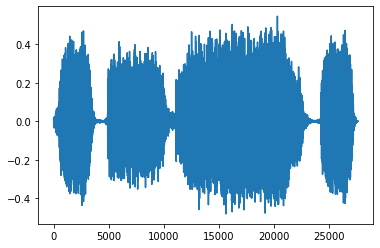

In [6]:
new_sample_rate = sample_rate/10

# Since Resample applies to a single channel, we resample first channel here
channel = 0
transformed = torchaudio.transforms.Resample(sample_rate, new_sample_rate)(waveform[channel,:].view(1,-1))

print("Shape of transformed waveform: {}".format(transformed.size()))

plt.figure()
plt.plot(transformed[0,:].numpy())

## Endode the waveform

Shape of transformed waveform: torch.Size([2, 276858])


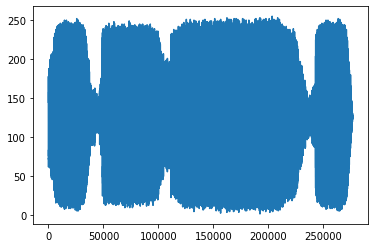

In [7]:
def normalize(tensor):
    # Subtract the mean, and scale to the interval [-1,1]
    tensor_minusmean = tensor - tensor.mean()
    return tensor_minusmean/tensor_minusmean.abs().max()

# Let's normalize to the full interval [-1,1]
waveform = normalize(waveform)

transformed = torchaudio.transforms.MuLawEncoding()(waveform)

print("Shape of transformed waveform: {}".format(transformed.size()))

plt.figure()
plt.plot(transformed[0,:].numpy())

## Decode the waveform

Shape of recovered waveform: torch.Size([2, 276858])


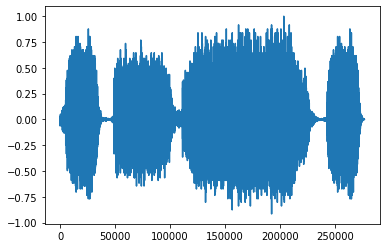

In [8]:
reconstructed = torchaudio.transforms.MuLawDecoding()(transformed)

print("Shape of recovered waveform: {}".format(reconstructed.size()))

plt.figure()
plt.plot(reconstructed[0,:].numpy())

## Compare the original waveform

In [10]:
# Compute median relative difference
err = ((waveform-reconstructed).abs() / waveform.abs()).median()

print("Median relative difference between original and MuLaw reconstucted signals: {:.2%}".format(err))

Median relative difference between original and MuLaw reconstucted signals: 1.22%


# Functional
The transformations seen above rely on lower level stateless functions for their computations. These functions are available under torchaudio.functional. 

## mu_law_encoding functional

Shape of transformed waveform: torch.Size([2, 276858])


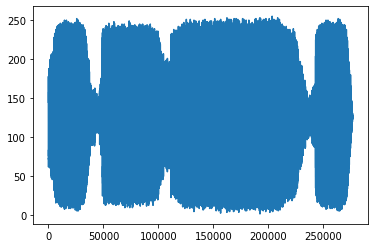

In [11]:
mu_law_encoding_waveform = torchaudio.functional.mu_law_encoding(waveform, quantization_channels=256)

print("Shape of transformed waveform: {}".format(mu_law_encoding_waveform.size()))

plt.figure()
plt.plot(mu_law_encoding_waveform[0,:].numpy())


## Spectogram

Shape of computed deltas: torch.Size([2, 128, 1385])


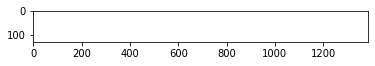

In [12]:
computed = torchaudio.functional.compute_deltas(specgram.contiguous(), win_length=3)
print("Shape of computed deltas: {}".format(computed.shape))

plt.figure()
plt.imshow(computed.log2()[0,:,:].detach().numpy(), cmap='gray')

## Different effects

In [13]:
gain_waveform = torchaudio.functional.gain(waveform, gain_db=5.0)
print("Min of gain_waveform: {}\nMax of gain_waveform: {}\nMean of gain_waveform: {}".format(gain_waveform.min(), gain_waveform.max(), gain_waveform.mean()))

dither_waveform = torchaudio.functional.dither(waveform)
print("Min of dither_waveform: {}\nMax of dither_waveform: {}\nMean of dither_waveform: {}".format(dither_waveform.min(), dither_waveform.max(), dither_waveform.mean()))

Min of gain_waveform: -1.7692409753799438
Max of gain_waveform: 1.778279423713684
Mean of gain_waveform: 1.8187664707625117e-09
Min of dither_waveform: -0.994842529296875
Max of dither_waveform: 0.999969482421875
Mean of dither_waveform: 1.5254325262503698e-05


## Lowpass biquad filter

Min of lowpass_waveform: -0.9717530012130737
Max of lowpass_waveform: 0.9714220762252808
Mean of lowpass_waveform: 2.8183559930283764e-09


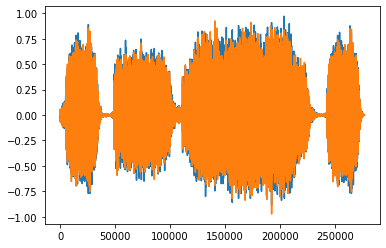

In [14]:
lowpass_waveform = torchaudio.functional.lowpass_biquad(waveform, sample_rate, cutoff_freq=3000)

print("Min of lowpass_waveform: {}\nMax of lowpass_waveform: {}\nMean of lowpass_waveform: {}".format(lowpass_waveform.min(), lowpass_waveform.max(), lowpass_waveform.mean()))

plt.figure()
plt.plot(lowpass_waveform.t().numpy())

## Highpass biquad filter

Min of highpass_waveform: -0.19568993151187897
Max of highpass_waveform: 0.18149901926517487
Mean of highpass_waveform: -8.288648933874043e-11


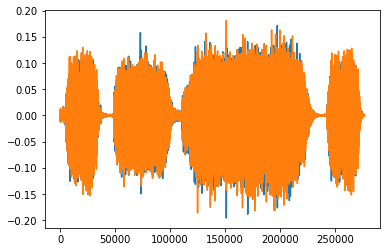

In [15]:
highpass_waveform = torchaudio.functional.highpass_biquad(waveform, sample_rate, cutoff_freq=2000)

print("Min of highpass_waveform: {}\nMax of highpass_waveform: {}\nMean of highpass_waveform: {}".format(highpass_waveform.min(), highpass_waveform.max(), highpass_waveform.mean()))

plt.figure()
plt.plot(highpass_waveform.t().numpy())

# Migrating to torchaudio from Kaldi

Kaldi is a toolkit for speech recognition.  
torchaudio offers compatibility with it in torchaudio.kaldi_io.

## Spectrogram

Shape of spectrogram: torch.Size([1383, 201])


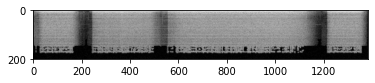

In [16]:
n_fft = 400.0
frame_length = n_fft / sample_rate * 1000.0
frame_shift = frame_length / 2.0

params = {
    "channel": 0,
    "dither": 0.0,
    "window_type": "hanning",
    "frame_length": frame_length,
    "frame_shift": frame_shift,
    "remove_dc_offset": False,
    "round_to_power_of_two": False,
    "sample_frequency": sample_rate,
}

specgram = torchaudio.compliance.kaldi.spectrogram(waveform, **params)

print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure()
plt.imshow(specgram.t().numpy(), cmap='gray')

## Filterbank features from waveforms

Shape of fbank: torch.Size([1383, 23])


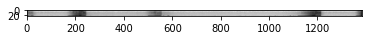

In [17]:
fbank = torchaudio.compliance.kaldi.fbank(waveform, **params)

print("Shape of fbank: {}".format(fbank.size()))

plt.figure()
plt.imshow(fbank.t().numpy(), cmap='gray')

## Mel frequency cepstral cofficients

Shape of mfcc: torch.Size([1383, 13])


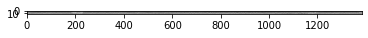

In [18]:
mfcc = torchaudio.compliance.kaldi.mfcc(waveform, **params)

print("Shape of mfcc: {}".format(mfcc.size()))

plt.figure()
plt.imshow(mfcc.t().numpy(), cmap='gray')

# Available Datasets
torchaudio offers a unified dataset interface. 





Waveform: tensor([[ 3.0518e-05,  6.1035e-05,  3.0518e-05,  ..., -1.8311e-04,
          4.2725e-04,  6.7139e-04]])
Sample rate: 8000
Labels: [0, 0, 1, 0, 0, 0, 1, 0]


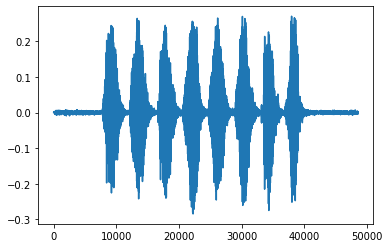

In [19]:
yesno_data = torchaudio.datasets.YESNO('./', download=True)

# A data point in Yesno is a tuple (waveform, sample_rate, labels) where labels is a list of integers with 1 for yes and 0 for no.

# Pick data point number 3 to see an example of the the yesno_data:
n = 3
waveform, sample_rate, labels = yesno_data[n]

print("Waveform: {}\nSample rate: {}\nLabels: {}".format(waveform, sample_rate, labels))

plt.figure()
plt.plot(waveform.t().numpy())

# Conclusion
We used an example raw audio signal, or waveform, to illustrate how to open an audio file using torchaudio, and how to pre-process, transform, and apply functions to such waveform. 